In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('zinc_prices_IMF.csv')
df.head()

,Date,Price
0,1-Jan-80,773.82
1,1-Feb-80,868.62
2,1-Mar-80,740.75
3,1-Apr-80,707.68
4,1-May-80,701.07


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 2 columns):
Date     434 non-null object
Price    434 non-null float64
dtypes: float64(1), object(1)
memory usage: 6.9+ KB


In [5]:
# convertinng date object  to datetime format
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
df.head()

,Date,Price
0,1980-01-01,773.82
1,1980-02-01,868.62
2,1980-03-01,740.75
3,1980-04-01,707.68
4,1980-05-01,701.07


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 2 columns):
Date     434 non-null datetime64[ns]
Price    434 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.9 KB


In [8]:
## Date colun is no converetd to Datetime format

In [9]:
df.set_index('Date', inplace=True)

In [10]:
df.head()

,Price
Date,
1980-01-01,773.82
1980-02-01,868.62
1980-03-01,740.75
1980-04-01,707.68
1980-05-01,701.07


# Visualize the time series

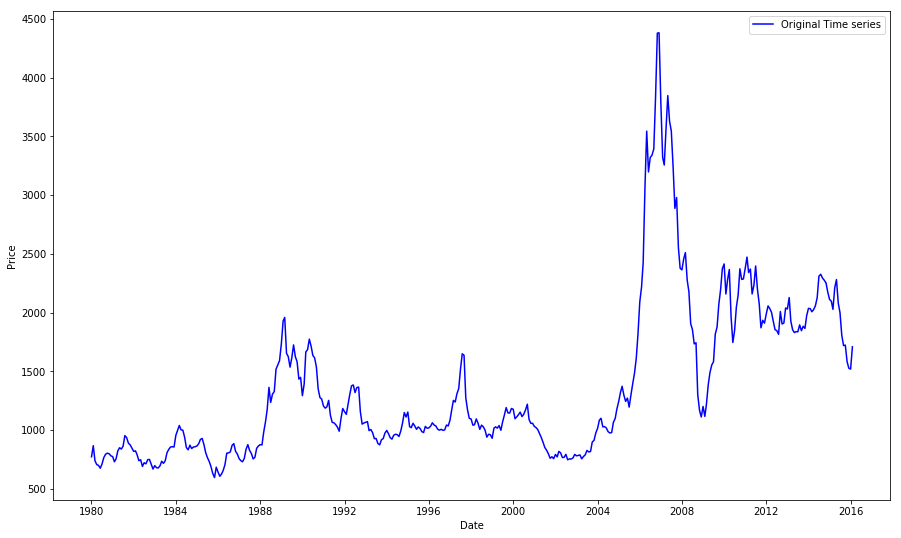

In [11]:
plt.figure(figsize=(15,9))
plt.plot(df['Price'], color='blue', label='Original Time series')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()

# Check for the stationarity of your data using Rolling Statistics and Dickey-Fuller test and if present,
# remove it using the stationarity removal techniques

In [12]:
# Checking Stationarity using Rolling Statistics

ts_rolling_mean = df['Price'].rolling(12).mean()
ts_rolling_std = df['Price'].rolling(12).std()

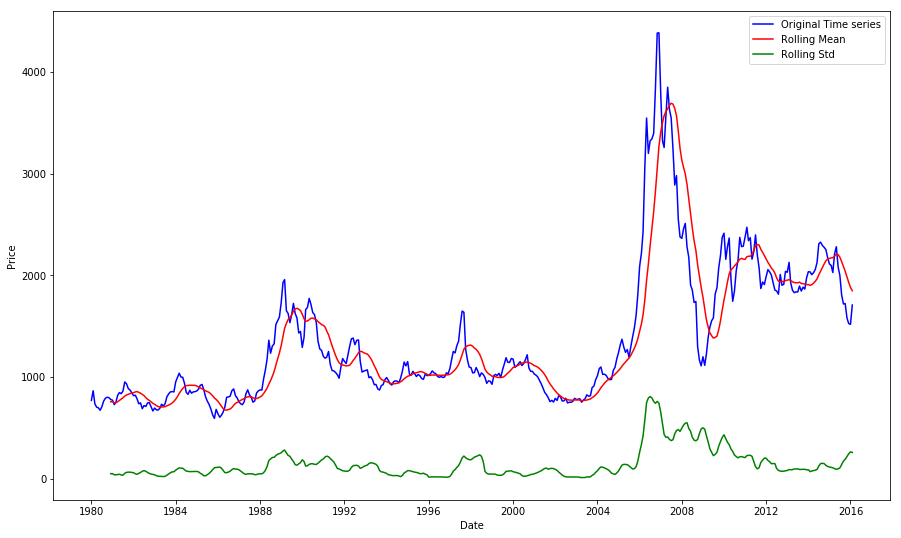

In [13]:
plt.figure(figsize=(15,9))
plt.plot(df['Price'], color='blue', label='Original Time series')
plt.plot(ts_rolling_mean, color='red', label='Rolling Mean')
plt.plot(ts_rolling_std, color='green', label='Rolling Std')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()

## Observations:
    * by looking at the rolling statistics, # we see that the rolling mean is in upward trend and the rolling std is slightly increasing,therefore wecan say that the time series is Non - Stationary

In [14]:
#checking the non stationarity using Dickey-Fuller test

# Null hypo thesis  = Time series in Non Stationary


from statsmodels.tsa.stattools import adfuller

In [15]:
adf_test = adfuller(df['Price'])
adf_test

(-3.139600554153094,
 0.023758021886102005,
 7,
 426,
 {'1%': -3.4457939940402107,
  '5%': -2.8683485906158963,
  '10%': -2.570396746236417},
 5069.9473477604715)

In [16]:
print(f'test statistics {adf_test[0]}')
print(f'P-value {adf_test[1]}')
print(f'Lags Used {adf_test[2]}')
print(f'No of observations {adf_test[3]}')

test statistics -3.139600554153094
P-value 0.023758021886102005
Lags Used 7
No of observations 426


## Observations:
    # p value is > 0.05, hence we accept the null hypothesis and say that the time series is Non Stationary

### Applying diferencing to make the time series stationary

In [17]:
nshifts=1
ts_zinc =df['Price']-df['Price'].shift(nshifts)
adfuller(ts_zinc[nshifts:])[1]

6.1982074610300765e-06

In [18]:
nshifts=2
ts_zinc =df['Price']-df['Price'].shift(nshifts)
adfuller(ts_zinc[nshifts:])[1]

4.42079320712585e-06

## Observations:
    # so while apply the 1st degree diferencing, we get that p value =6.19820746102993e-06 = 0.00000619 which is < 0.005,
    # hence we can reject the null hypothesis now and say that the time series is now stationary

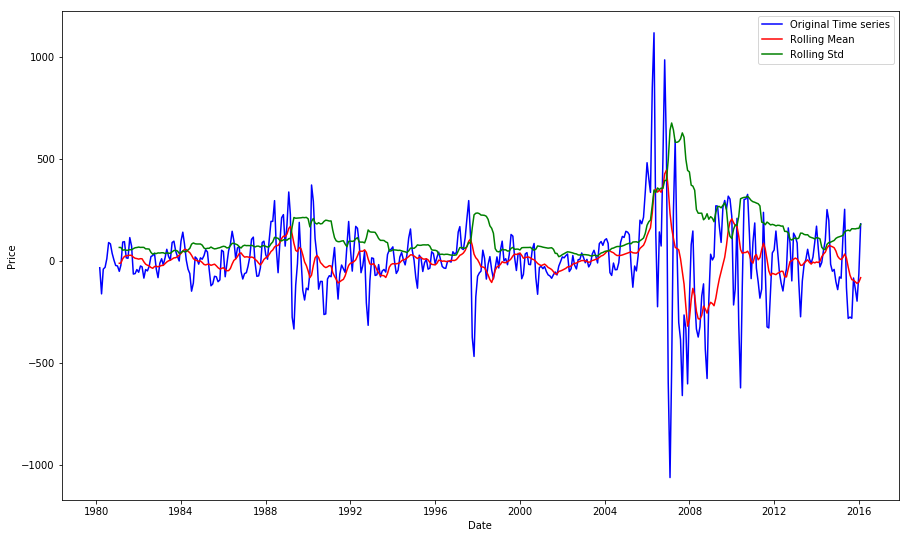

In [19]:
# Plotting the timeseries after making the time series stationary

ts_zinc_rolling_mean = ts_zinc.rolling(12).mean()
ts_zinc_rolling_std = ts_zinc.rolling(12).std()

plt.figure(figsize=(15,9))
plt.plot(ts_zinc, color='blue', label='Original Time series')
plt.plot(ts_zinc_rolling_mean, color='red', label='Rolling Mean')
plt.plot(ts_zinc_rolling_std, color='green', label='Rolling Std')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()

### Hence the value for d = 1

# Plot ACF and PACF plots. Find the p and q values

In [20]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

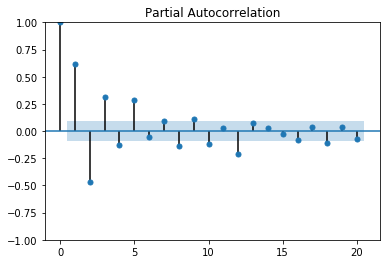

In [21]:
plot_pacf(ts_zinc[nshifts:],lags=20)
plt.show()

### here the the pacf, goes below zero after after lag=2, or p order can be either 1 or 2
### so, we can take p = 2

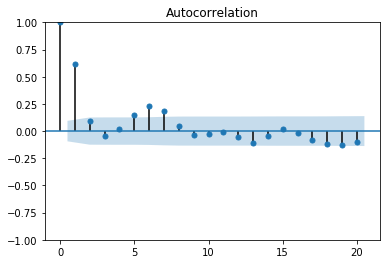

In [22]:
plot_acf(ts_zinc[nshifts:],lags=20)
plt.show()

### here the acf, the point at which it has cross the upper confidence bound, so, q = 1

# Perform ARIMA modeling

In [23]:
df.shape[0]/2


217.0

In [24]:
# Splitting the data into trai and test
train = df['Price'][:217]
test = df['Price'][217:]

print(train.shape)
print(test.shape)

(217,)
(217,)


In [39]:
# Build Model 
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train, order=(2, 1, 1))  
fitted = model.fit()

In [40]:
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  217
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1219.665
Date:                Mon, 11 Oct 2021   AIC                           2447.329
Time:                        21:48:14   BIC                           2460.831
Sample:                    01-01-1980   HQIC                          2452.784
                         - 01-01-1998                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2252      0.065     18.816      0.000       1.098       1.353
ar.L2         -0.2669      0.063     -4.229      0.000      -0.391      -0.143
ma.L1         -0.9880      0.026    -38.375      0.000      -1.038      -0.938
sigma2      4686.6833    266.318     17.598      0.000    4164.709    5208.657
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               223.82
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.43   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
# Forecast
fc, se, conf = fitted.forecast(217, alpha=0.05)  # 95% conf

ValueError: too many values to unpack (expected 2)

In [27]:
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

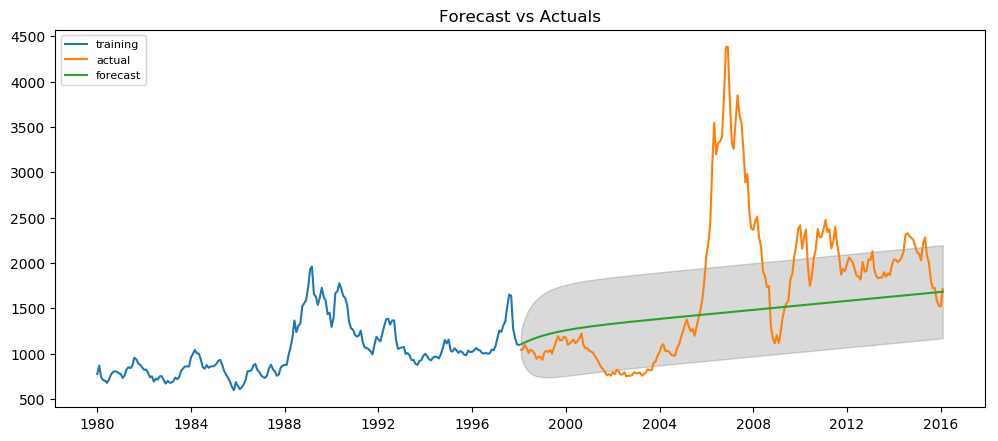

In [28]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [29]:
from sklearn.metrics import mean_absolute_percentage_error

In [30]:
1-mean_absolute_percentage_error(fc_series,test.values)

0.6350685945892995

## With p =2, d= 1 and q = 1, we see that the p value is < 0.05 but the mean_absolute_percentage_error is just around 63.5%


In [31]:
train = df['Price'][:400]
test = df['Price'][400:]

print(train.shape)
print(test.shape)

# Build Model 
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train, order=(1, 2, 1))  
fitted = model.fit(disp=-1)
fitted.summary()

(400,)
(34,)


C:\Users\SujitSonar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\SujitSonar\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.Price   No. Observations:                  398
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -2439.441
Method:                       css-mle   S.D. of innovations            110.347
Date:                Mon, 11 Oct 2021   AIC                           4886.882
Time:                        19:45:01   BIC                           4902.828
Sample:                    03-01-1980   HQIC                          4893.198
                         - 04-01-2013                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0025      0.070     -0.036      0.971      -0.139       0.134
ar.L1.D2.Price     0.3133      0.048      6.560      0.000       0.220       0.407
ma.L1.D2.Price    -0.9999      0.007   -147.684      0.000      -1.013      -0.987
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.1918           +0.0000j            3.1918            0.0000
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

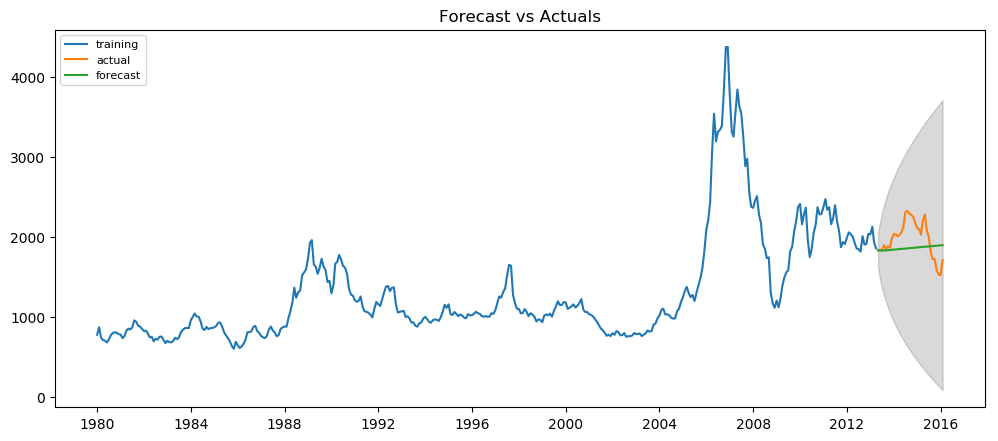

In [32]:
# Forecast
fc, se, conf = fitted.forecast(34, alpha=0.05)  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [33]:
1-mean_absolute_percentage_error(fc_series,test.values)

0.88442440998785

### reducing the test dataset to just 34 rows and with p =1, d= 1 and q = 1, we see that the p value is < 0.05 and the mean_absolute_percentage_error is just around 88.4%

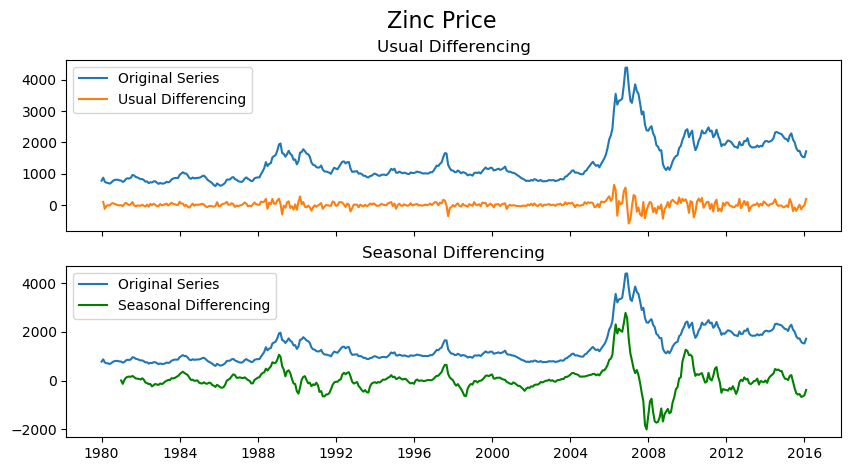

In [29]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(df[:], label='Original Series')
axes[0].plot(df[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
axes[1].plot(df[:], label='Original Series')
axes[1].plot(df[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Zinc Price', fontsize=16)
plt.show()

In [32]:
import pmdarima as pm

In [33]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(df, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.20 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=6518.596, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=5418.313, Time=0.93 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=6517.959, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=5500.204, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=5341.438, Time=4.90 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=5.11 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.74 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=6437.798, Time=4.31 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=5287.005, Time=5.11 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=5355.386, Time=1.12 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=7.19 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=2.62 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : AIC=5286.1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  434
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 12)   Log Likelihood               -2636.076
Date:                            Mon, 11 Oct 2021   AIC                           5284.153
Time:                                    21:44:08   BIC                           5308.423
Sample:                                         0   HQIC                          5293.744
                                            - 434                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3465      0.033     41.362      0.000       1.283       1.410
ar.L2         -0.4644      0.049     -9.559      0.000      -0.560      -0.369
ar.L3          0.0832      0.030      2.730      0.006       0.023       0.143
ar.S.L12      -0.5996      0.042    -14.160      0.000      -0.683      -0.517
ar.S.L24      -0.3943      0.034    -11.493      0.000      -0.461      -0.327
sigma2      1.529e+04    545.665     28.012      0.000    1.42e+04    1.64e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1058.81
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               5.07   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

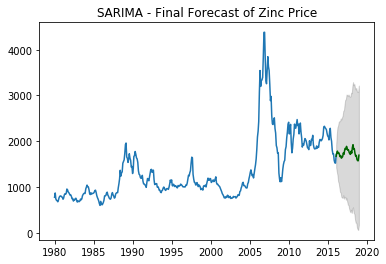

In [37]:
# Forecast
n_periods = 36
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of Zinc Price")
plt.show()